## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import numpy as np
import os
import math
import collections

## Load Data

In [2]:
# class Observation:
#     def __init__(self, mag_field_volt, mag_field_curr, filter, sample, min_trans_eye,
#                 angles, intensities):
#         self.mag_field_volt = mag_field_volt
#         self.mag_field_curr = mag_field_curr
#         self.filter = filter
#         self.sample = sample
#         self.min_trans_eye = min_trans_eye
#         self.angles = angles
#         self.intensities = intensities

from faraday_common import Observation

In [3]:
data_file = 'data/faraday_data.xlsx'

In [4]:
full_df = pd.read_excel(data_file)
full_df

,Magnetic Field voltage (V),Magnetic Field Current (Amps),Filter,Sample (cm),Min transmission angle,Unnamed: 5,Angle 1,Value 1,Angle 2,Value 2,...,Value 6,Angle 7,Value 7,Angle 8,Value 8,Angle 9,Value 9,Unnamed: 24,Zero Field Angle,Intensity
0,0,0.00,Red,1.036,334,NaN,294,0.0315,304,0.0205,...,0.00250,354,0.00760,364,0.0170,374,0.0300,NaN,335.274926,0.00101
1,0,0.00,Red,0.956,332,NaN,292,0.0426,302,0.0271,...,0.00275,352,0.00672,362,0.0137,372,0.0214,NaN,338.287840,0.00269
2,0,0.00,Red,1.272,339,NaN,299,0.0223,309,0.0134,...,0.00447,359,0.01080,369,0.0186,379,0.0275,NaN,335.957915,0.00211
3,0,0.00,Blue,1.272,332,NaN,292,0.0526,302,0.0378,...,0.00696,352,0.01580,362,0.0300,372,0.0457,NaN,334.224460,0.00517
4,0,0.00,Blue,0.956,340,NaN,300,0.0548,310,0.0359,...,0.01620,360,0.03240,370,0.0508,380,0.0646,NaN,336.576890,0.00729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,-30,-1.22,Blue,1.272,346,NaN,306,0.0210,316,0.0139,...,0.00360,366,0.00878,376,0.0157,386,0.0234,NaN,334.224460,0.01000
59,-30,-1.22,Blue,1.036,313,NaN,273,0.0532,283,0.0379,...,0.00499,333,0.01600,343,0.0310,353,0.0468,NaN,336.148007,0.01630
60,-30,-1.22,Red,0.956,341,NaN,301,0.0230,311,0.0133,...,0.00615,361,0.01290,371,0.0222,381,0.0313,NaN,338.287840,0.00293
61,-30,-1.22,Red,1.272,340,NaN,300,0.0249,310,0.0156,...,0.00202,360,0.00608,370,0.0118,380,0.0194,NaN,335.957915,0.00234


In [5]:
observation_arr = []
for i, row in full_df.iterrows():
    mag_field_volt, mag_field_curr, filter, sample, min_trans_eye = row[0:5].values
    angles = [row[f"Angle {j}"] for j in range(1, 10)]
    intensities = [row[f"Value {j}"] for j in range(1, 10)]
    observation = Observation(mag_field_volt, 
                              mag_field_curr, 
                              filter, 
                              sample, 
                              min_trans_eye, 
                              angles, 
                              intensities)
    observation_arr.append(observation)

## Malus Fit Class

In [6]:
# class MalusFit:
#     def __init__(self, observation):
#         self.observation = observation
#         self.angles = observation.angles
#         self.intensities = observation.intensities
#         self.fit()
        
#     def fit(self):
#         """
#         Fit malus curve to angles and intensities
#         """
#         m1_guess = np.max(intensities)
#         m2_guess = np.max(intensities)
#         m3_guess = angles[np.argmin(intensities)]
#         params, covariance = curve_fit(self.malus_curve, 
#                                            self.angles, 
#                                            self.intensities, 
#                                            p0=[m1_guess, m2_guess, m3_guess])
#         self.m1, self.m2, self.m3 = params
        
#     def malus_curve(self, x, m1, m2, m3):
#         return m1 - m2 * (np.cos(np.deg2rad(x - m3))) ** 2

#     def get_min_angle(self):
#         """
#         Find the minimum transmission angle based on fit parameters
#         """
#         return self.m3

#     def plot_fit(self, ax):
#         """
#         Plot malus fit to intensities, with both data and fitted curve
#         """
#         fit_angles = np.linspace(np.min(self.angles), 
#                                  np.max(self.angles), 
#                                  100)
#         fitted_intensities = self.malus_curve(fit_angles, 
#                                               self.m1, 
#                                               self.m2, 
#                                               self.m3)
#         ax.plot(fit_angles, fitted_intensities, color = "red")
#         ax.scatter(self.angles, self.intensities)
#         ax.set_title(f"{self.observation.mag_field_volt} V," 
#                      f"{self.observation.filter},"
#                      f"{self.observation.sample}")

from faraday_common import MalusFit

## Create 0 magnetic field fits

In [7]:
import collections
zero_field_angles = collections.defaultdict(dict)

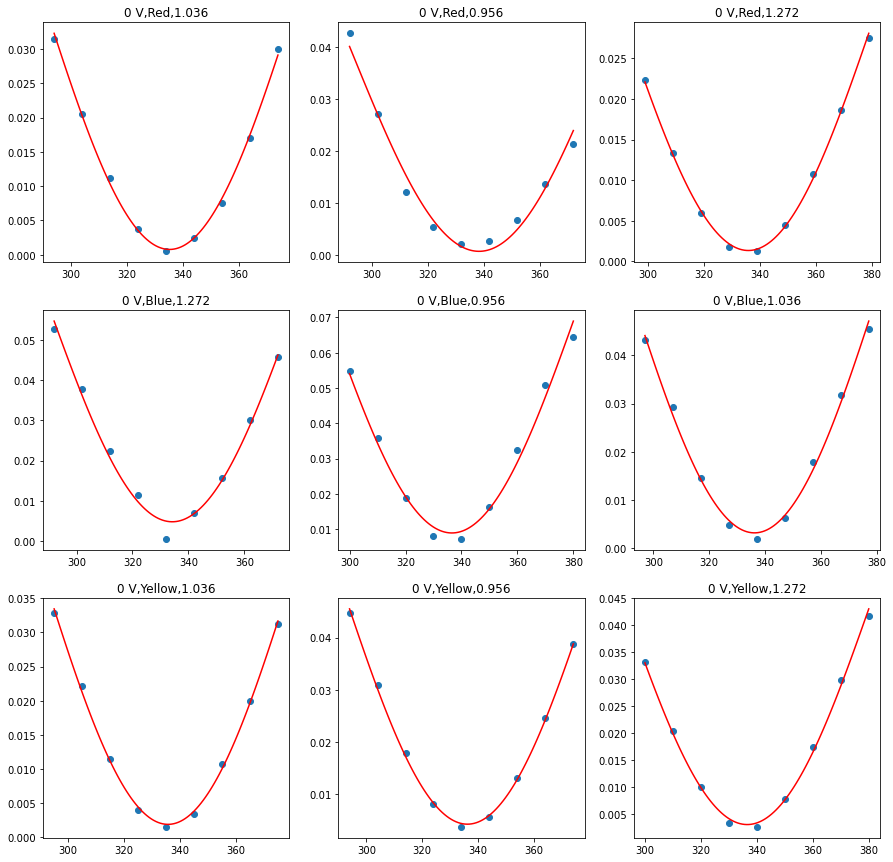

In [8]:
## Fit the 9 0 field datapoints
fig, axes = plt.subplots(3, 3, figsize = (15, 15))
for i, ax in enumerate(axes.flatten()):
    observation = observation_arr[i]
    mf = MalusFit(observation)
    mf.plot_fit(ax)
    zero_field_angles[observation.filter][observation.sample] = mf.get_min_angle()

In [9]:
zero_field_angles

defaultdict(dict,
            {'Red': {1.036: 335.274925890484,
              0.956: 338.28784039026385,
              1.272: 335.95791532842117},
             'Blue': {1.272: 334.2244603785799,
              0.956: 336.57688964189674,
              1.036: 336.1480069830858},
             'Yellow': {1.036: 335.6961290674026,
              0.956: 336.1317016374635,
              1.272: 336.54722589233563}})

In [10]:
full_df["zero_field_angle"] = 0

In [11]:
full_df

,Magnetic Field voltage (V),Magnetic Field Current (Amps),Filter,Sample (cm),Min transmission angle,Unnamed: 5,Angle 1,Value 1,Angle 2,Value 2,...,Angle 7,Value 7,Angle 8,Value 8,Angle 9,Value 9,Unnamed: 24,Zero Field Angle,Intensity,zero_field_angle
0,0,0.00,Red,1.036,334,NaN,294,0.0315,304,0.0205,...,354,0.00760,364,0.0170,374,0.0300,NaN,335.274926,0.00101,0
1,0,0.00,Red,0.956,332,NaN,292,0.0426,302,0.0271,...,352,0.00672,362,0.0137,372,0.0214,NaN,338.287840,0.00269,0
2,0,0.00,Red,1.272,339,NaN,299,0.0223,309,0.0134,...,359,0.01080,369,0.0186,379,0.0275,NaN,335.957915,0.00211,0
3,0,0.00,Blue,1.272,332,NaN,292,0.0526,302,0.0378,...,352,0.01580,362,0.0300,372,0.0457,NaN,334.224460,0.00517,0
4,0,0.00,Blue,0.956,340,NaN,300,0.0548,310,0.0359,...,360,0.03240,370,0.0508,380,0.0646,NaN,336.576890,0.00729,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,-30,-1.22,Blue,1.272,346,NaN,306,0.0210,316,0.0139,...,366,0.00878,376,0.0157,386,0.0234,NaN,334.224460,0.01000,0
59,-30,-1.22,Blue,1.036,313,NaN,273,0.0532,283,0.0379,...,333,0.01600,343,0.0310,353,0.0468,NaN,336.148007,0.01630,0
60,-30,-1.22,Red,0.956,341,NaN,301,0.0230,311,0.0133,...,361,0.01290,371,0.0222,381,0.0313,NaN,338.287840,0.00293,0
61,-30,-1.22,Red,1.272,340,NaN,300,0.0249,310,0.0156,...,360,0.00608,370,0.0118,380,0.0194,NaN,335.957915,0.00234,0


In [12]:
for i, row in full_df.iterrows():
    filter = row['Filter']
    sample = row['Sample (cm)']
    full_df.at[i, "zero_field_angle"] = zero_field_angles[filter][sample]

In [13]:
full_df

,Magnetic Field voltage (V),Magnetic Field Current (Amps),Filter,Sample (cm),Min transmission angle,Unnamed: 5,Angle 1,Value 1,Angle 2,Value 2,...,Angle 7,Value 7,Angle 8,Value 8,Angle 9,Value 9,Unnamed: 24,Zero Field Angle,Intensity,zero_field_angle
0,0,0.00,Red,1.036,334,NaN,294,0.0315,304,0.0205,...,354,0.00760,364,0.0170,374,0.0300,NaN,335.274926,0.00101,335
1,0,0.00,Red,0.956,332,NaN,292,0.0426,302,0.0271,...,352,0.00672,362,0.0137,372,0.0214,NaN,338.287840,0.00269,338
2,0,0.00,Red,1.272,339,NaN,299,0.0223,309,0.0134,...,359,0.01080,369,0.0186,379,0.0275,NaN,335.957915,0.00211,335
3,0,0.00,Blue,1.272,332,NaN,292,0.0526,302,0.0378,...,352,0.01580,362,0.0300,372,0.0457,NaN,334.224460,0.00517,334
4,0,0.00,Blue,0.956,340,NaN,300,0.0548,310,0.0359,...,360,0.03240,370,0.0508,380,0.0646,NaN,336.576890,0.00729,336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,-30,-1.22,Blue,1.272,346,NaN,306,0.0210,316,0.0139,...,366,0.00878,376,0.0157,386,0.0234,NaN,334.224460,0.01000,334
59,-30,-1.22,Blue,1.036,313,NaN,273,0.0532,283,0.0379,...,333,0.01600,343,0.0310,353,0.0468,NaN,336.148007,0.01630,336
60,-30,-1.22,Red,0.956,341,NaN,301,0.0230,311,0.0133,...,361,0.01290,371,0.0222,381,0.0313,NaN,338.287840,0.00293,338
61,-30,-1.22,Red,1.272,340,NaN,300,0.0249,310,0.0156,...,360,0.00608,370,0.0118,380,0.0194,NaN,335.957915,0.00234,335


In [14]:
full_df.to_excel("data/temp_data.xlsx")